In [15]:
import os
import glob
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys, getopt
import argparse
from decimal import *


In [16]:
isa='riscv'
vlen='256'
target = isa + '+' + vlen
spec = 'fp'

In [17]:
data = []
fields = ['A','Float','RV32A','RV32C','RV32D','RV32F','RV32I','RV32M','RV64A','RV64I','RV64M','RV64V','Zicsr','nclas','sum'] if 'riscv' in target  else (
            'A', 'SVE', 
            'PCrel addr', 'Add/Sub (imm,tags)', 'Add/Sub (imm)', 'Logical (imm)', 'Move Wide (imm)', 'Bitfield', 'Extract', 'Data Proc Imm',
            'Cond Branch (imm)', 'Exception Gen', 'NOP', 'Hints', 'Barriers', 'System Insn',  'System Reg',  'Branch (reg)', 'Branch (imm)',  'Cmp & Branch', 'Tst & Branch', 'Branches', 
            'AdvSimd ldstmult', 'AdvSimd ldstmult++', 'AdvSimd ldst', 'AdvSimd ldst++', 'ldst excl',  'Prefetch', 'Load Reg (lit)', 'ldst noalloc pair', 'ldst pair', 'ldst reg', 'Atomic ldst', 'ldst reg (reg off)', 'ldst reg (pac)', 'ldst reg (imm)', 'Loads & Stores', 
            'Data Proc Reg',  
            'AdvSimd Scalar', 'AdvSimd other', 'Scalar FP', 'sum')

arm_class = {
            'A': [], 'sum': [],  
            'SVE': ['SVE'], 
            'Data Processing Immediate': ['PCrel addr', 'Add/Sub (imm,tags)', 'Add/Sub (imm)', 'Logical (imm)', 'Move Wide (imm)', 'Bitfield', 'Extract', 'Data Proc Imm'], 
            'Branches': ['Cond Branch (imm)', 'Exception Gen', 'NOP', 'Hints', 'Barriers', 'System Insn',  'System Reg',  'Branch (reg)', 'Branch (imm)',  'Cmp & Branch', 'Tst & Branch', 'Branches'], 
            'Loads and Stores': ['ldst excl',  'Prefetch', 'Load Reg (lit)', 'ldst noalloc pair', 'ldst pair', 'ldst reg', 'Atomic ldst', 'ldst reg (reg off)', 'ldst reg (pac)', 'ldst reg (imm)', 'Loads & Stores'], 
            'Data Processing Register': ['Data Proc Reg'], 
            'Scalar FP': ['Scalar FP'], 
            'Neon': ['AdvSimd ldstmult', 'AdvSimd ldstmult++', 'AdvSimd ldst', 'AdvSimd ldst++','AdvSimd Scalar', 'AdvSimd other']
          }


dir = "/home/jerry/Speckle/"
BENCHMARKS=["bzip2", "gcc",  "mcf", "gobmk" , "hmmer" , "sjeng"  ,"libquantum", "h264ref", "omnetpp" ,"astar", "Xalan"] if spec == 'int' else ["dealII", 'lbm', 'milc', 'namd', 'povray', 'soplex', 'sphinx']
# BENCHMARKS=['h264ref']


In [18]:
def prune(string: str):
    i = 0
    j = len(string) - 1

    while ('a' > string[i] or string[i] > 'z') and ('A' > string[i] or string[i] > 'Z') and string[i] != ')':
        i += 1
    
    while ('a' > string[j] or string[j] > 'z') and ('A' > string[j] or string[j] > 'Z') and string[j] != ')':
        j -= 1

    # print(string[i:j+1])
    
    return string[i:j+1]


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['Spectral'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    # ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts.max(), height=0.5,
                        label=colname, color=color, align='center')

        r, g, b, _ = color
        text_color = 'black'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax

[{'A': 'O3_Nloop', 'Branches': 0.157, 'Data Processing Immediate': 0.111, 'Data Processing Register': 0.156, 'Loads and Stores': 0.487, 'Neon': 0.007, 'SVE': 0.0, 'Scalar FP': 0.081, 'sum': 0.0}, {'A': 'O3', 'Branches': 0.157, 'Data Processing Immediate': 0.111, 'Data Processing Register': 0.157, 'Loads and Stores': 0.487, 'Neon': 0.008, 'SVE': 0.0, 'Scalar FP': 0.081, 'sum': 0.0}, {'A': 'O3_Nslp', 'Branches': 0.156, 'Data Processing Immediate': 0.11, 'Data Processing Register': 0.155, 'Loads and Stores': 0.484, 'Neon': 0.001, 'SVE': 0.0, 'Scalar FP': 0.094, 'sum': 0.0}, {'A': 'O3_Nslp_Nloop', 'Branches': 0.156, 'Data Processing Immediate': 0.11, 'Data Processing Register': 0.155, 'Loads and Stores': 0.484, 'Neon': 0.0, 'SVE': 0.0, 'Scalar FP': 0.095, 'sum': 0.0}, {'A': 'O3_Nloop', 'Branches': 0.157, 'Data Processing Immediate': 0.111, 'Data Processing Register': 0.156, 'Loads and Stores': 0.487, 'Neon': 0.007, 'SVE': 0.0, 'Scalar FP': 0.081, 'sum': 0.992}, {'A': 'O3', 'Branches': 0.15

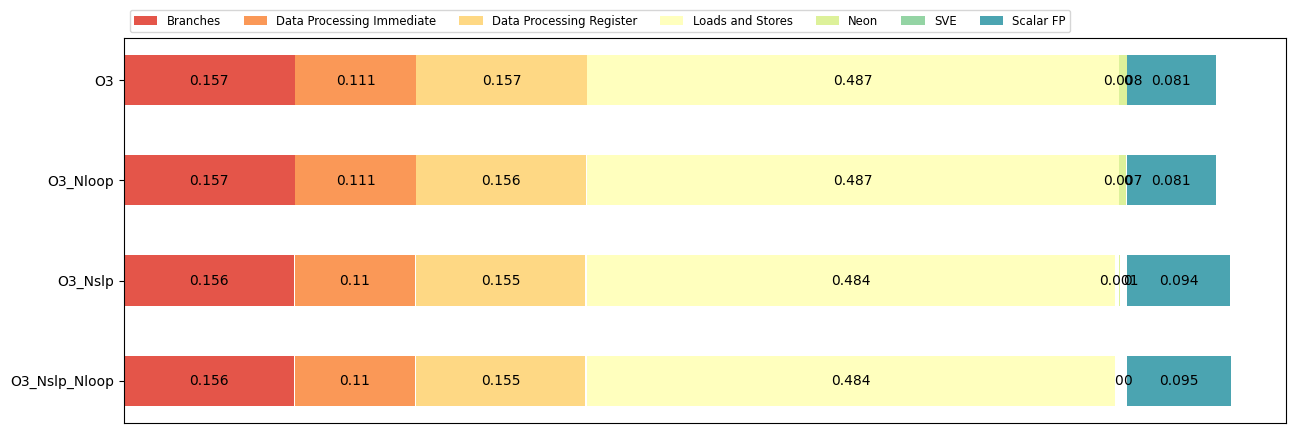

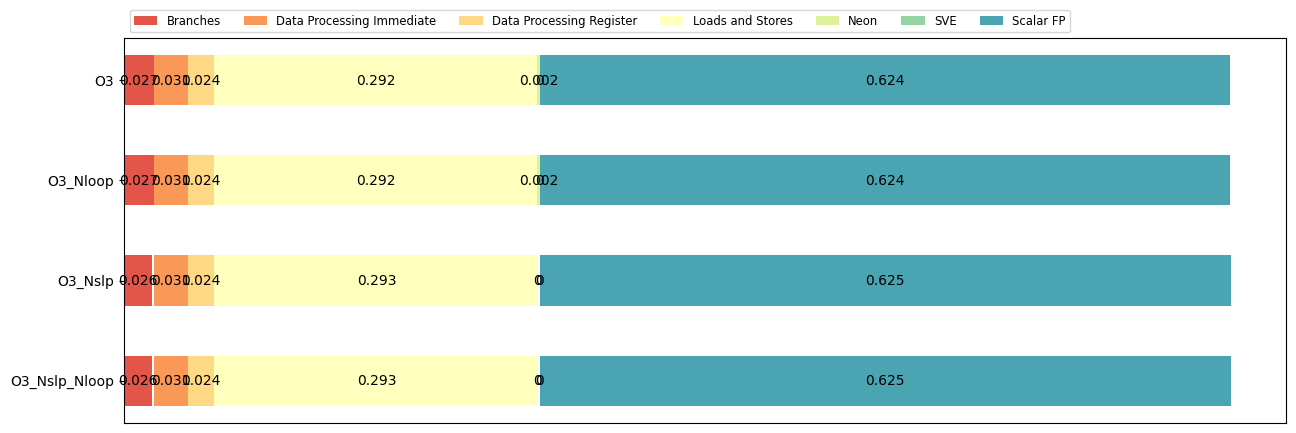

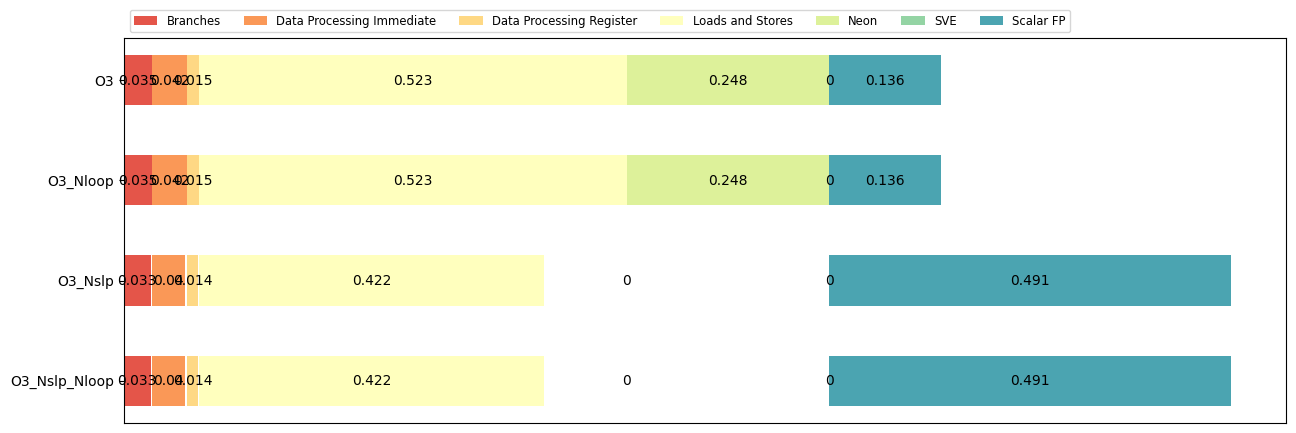

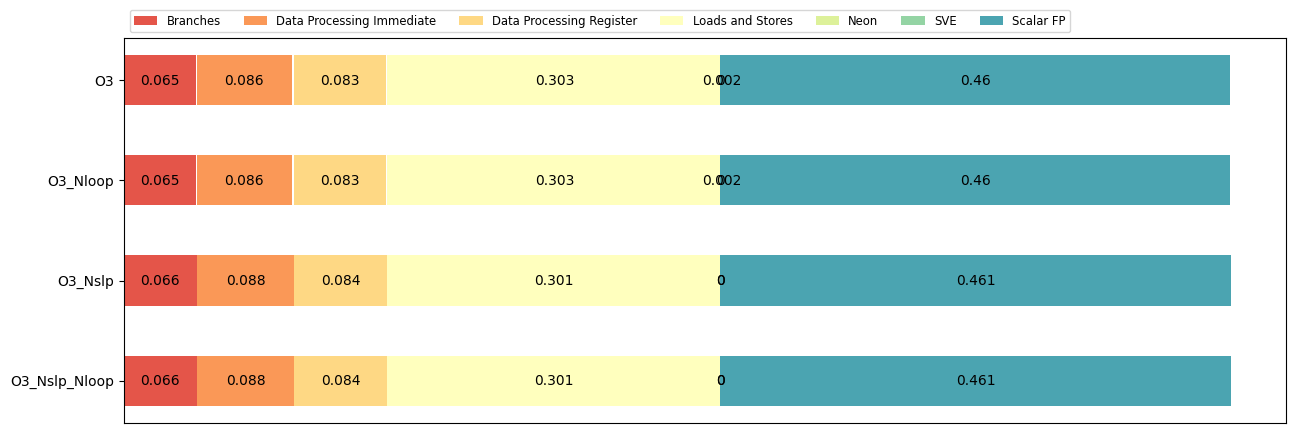

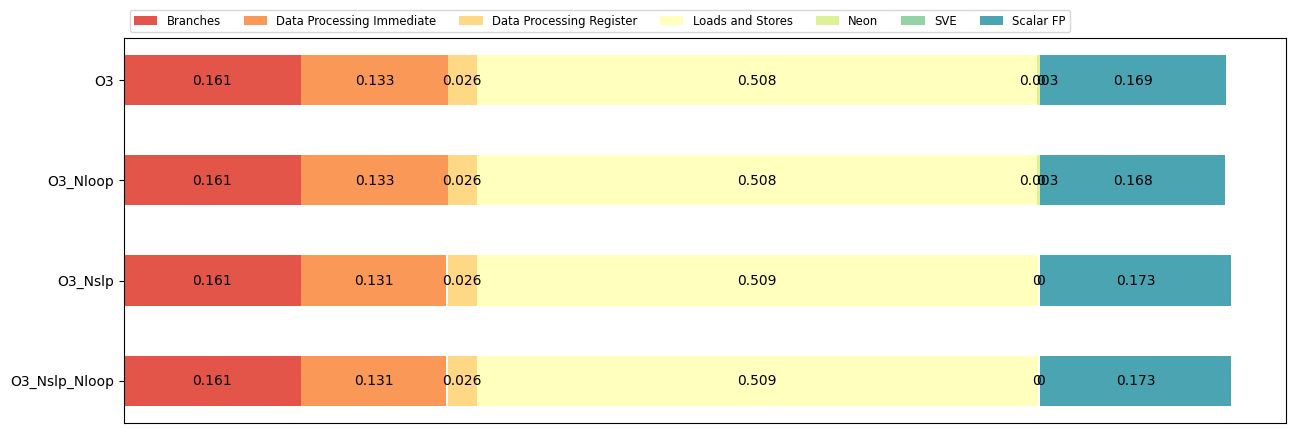

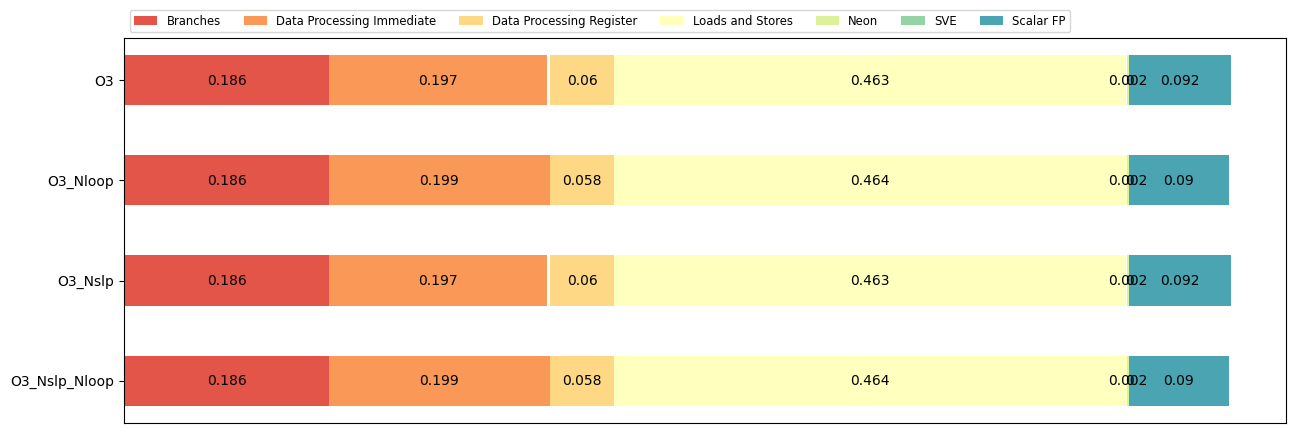

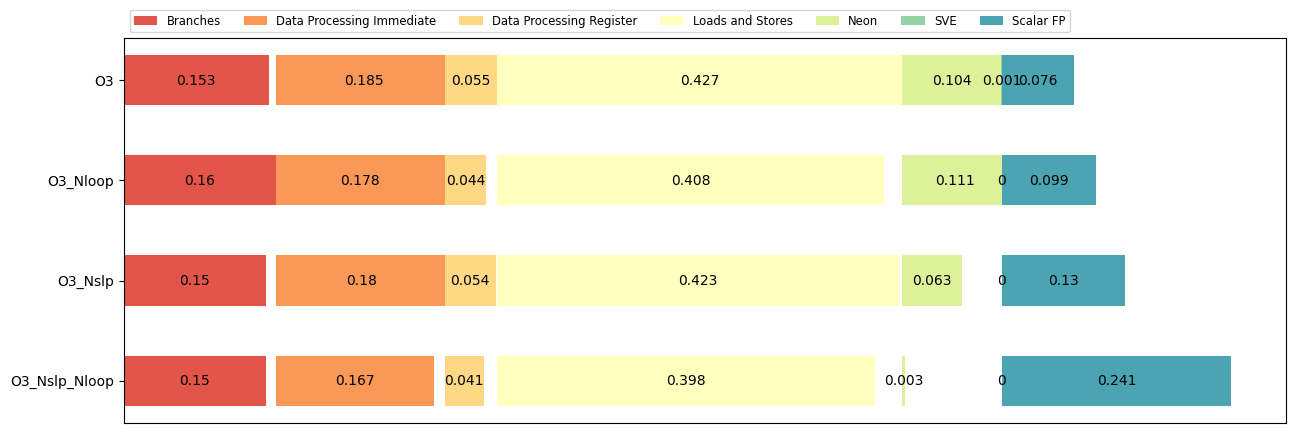

In [23]:
for benchmark in BENCHMARKS:
    for file in glob.iglob('result/' + target + '_' + spec + '*/*.out', recursive=True):

        # print("Processing {} ...".format(file))

        if file.find(benchmark) == -1:
            # print("Skipping")
            continue
        
        fp = open(dir + file, 'r')
        lines = fp.readlines()    

        m = dict()
        sum = 0

        for line in lines:
            if line[0:5] != 'Class':
                continue

            line = line.split('\t')
            num = line[1].split(' ')[0][1:]

            if '0' > num[0] or num[0] > '9':
                continue

            count = int(num)
            category = line[0][13:18] if 'riscv' in target  else prune(line[0][6:])

            if 'arm' in target:
                for key in arm_class.keys():
                    if category in arm_class[key]:
                        category = key
                        break

            if category not in m.keys():
                m.setdefault(category, 0)
            
            m[category] += count
            sum += count
        
        for key in m.keys():
            m[key] = round(m[key] / sum, 3)

        
        m.setdefault("sum", sum)
        m.setdefault("A", '_'.join(file.split('/')[1].split('_')[2:]))
        
        data.append(dict(sorted(m.items())))


    # data.insert(0, data.pop())
    # data.insert(0, data.pop())
    # print(file)
    # print(benchmark)
    # print(data)
    # print(m)

    for i in range(0, len(data)):
        if 'O3_Nslp_Nloop' in data[i].values():
            std = data[i]['sum']

    for i in range(0, len(data)):
        data[i]['sum'] = round(data[i]['sum'] / std, 3)
    
    # data[0]['sum'] = 1
    print(data)

    result = {data[i]['A']: [val for val in data[i].values()][1:-1] for i in range(len(data))}
    result = dict(sorted(result.items()))
    
    print(result)

    survey(results=result, category_names=[i for i in data[0].keys()][1:-1])
    plt.savefig("./fig/" + target + '_' + benchmark + ".png")

    if not os.path.exists(dir + "stat/" + target):
        os.mkdir(dir + "stat/" + target)

    with open(dir + "stat/" + target + "/" + benchmark + "_output.csv", "w+", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fields if 'riscv' in target else arm_class.keys())
        
        writer.writeheader()
        
        for row in data:
            writer.writerow(row)
    
    data.clear()


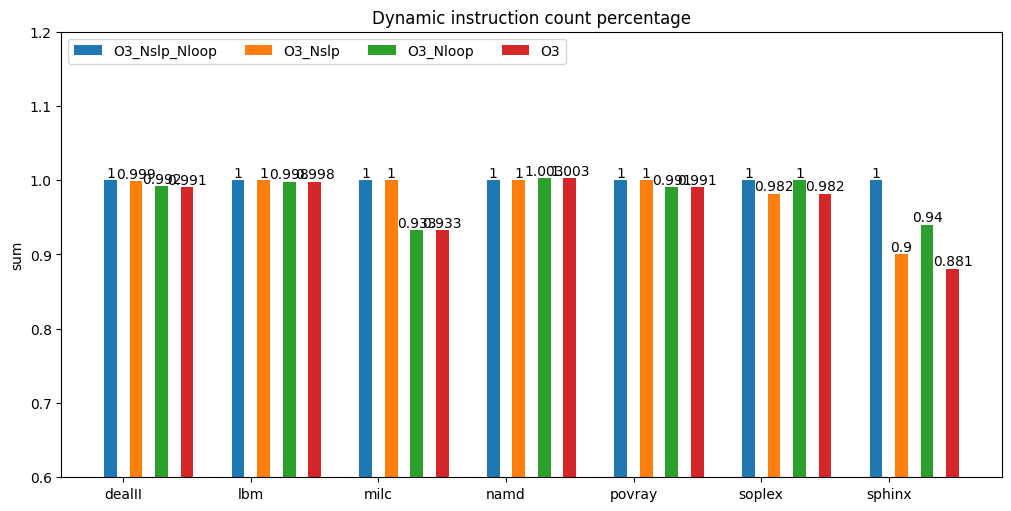

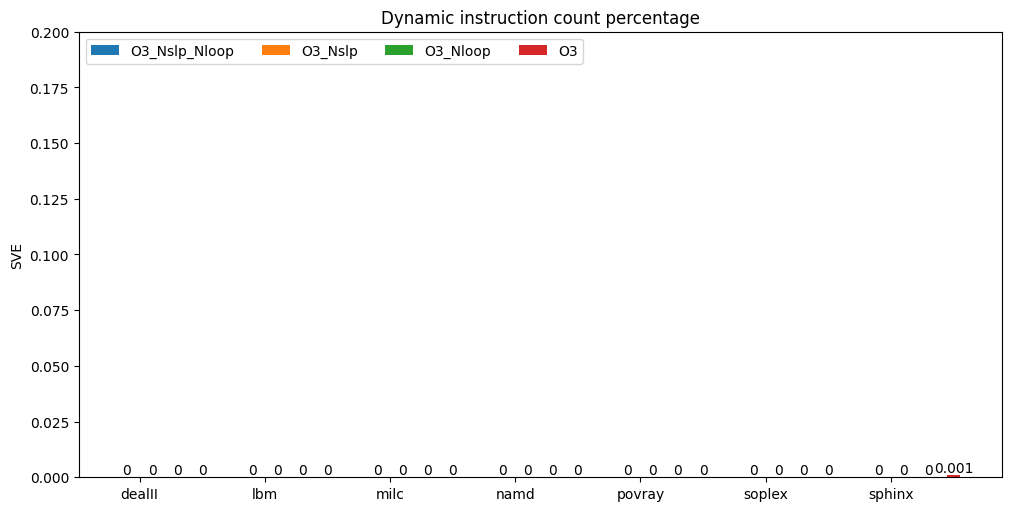

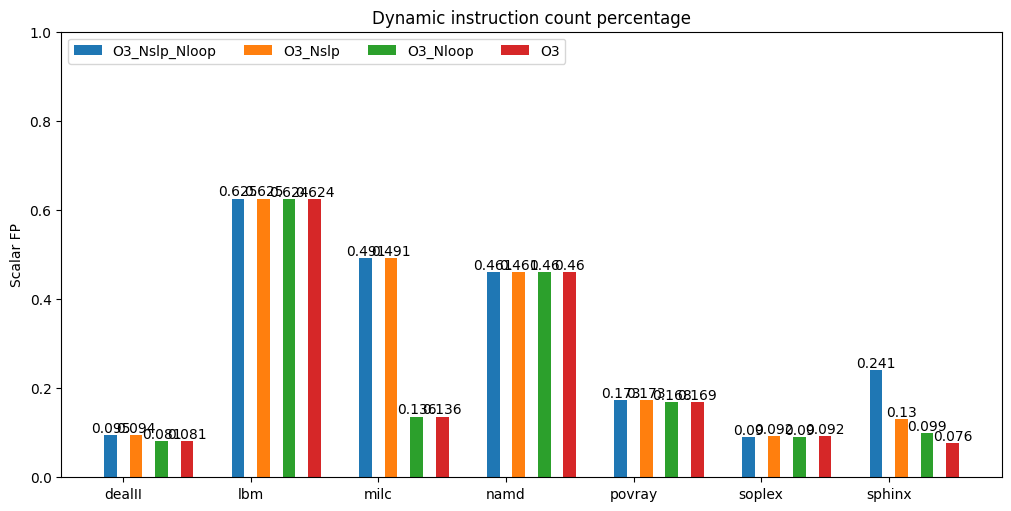

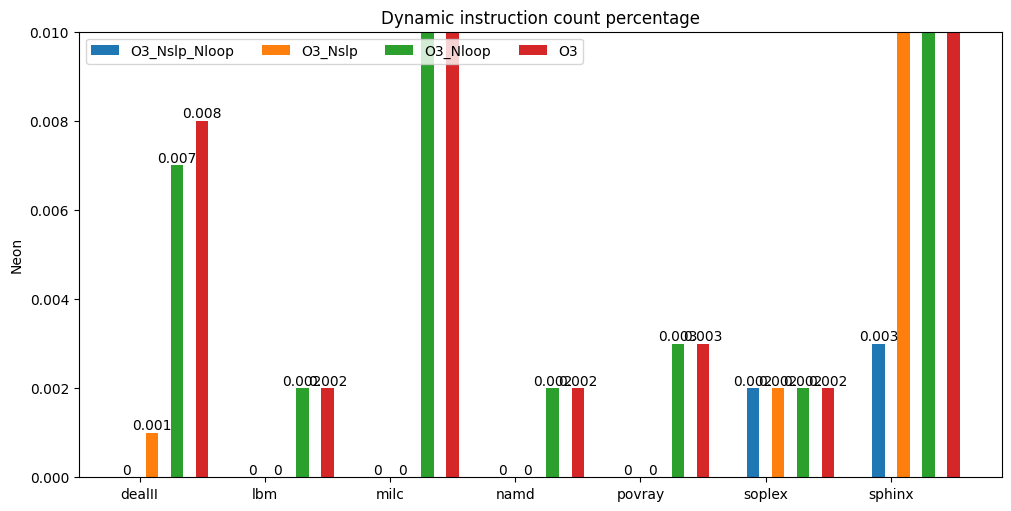

In [20]:
df = pd.DataFrame()
cnt = 0

for benchmark in BENCHMARKS:
    for file in glob.iglob('stat/' + target + '/*', recursive=True):
        if file.find(benchmark) == -1:
            continue
        
        cur = pd.read_csv(file)
        cur.index = [benchmark] * len(cur.axes[0])
        cur = cur.sort_values(by=['A'], ascending=False)
        # cur.drop('sum', axis=1).plot.barh(x='A', stacked=True)
        # plt.savefig('tmp.png')
        df = pd.concat([df, cur])
        # print([benchmark * len(df.axes[0])])
        # df.index = [benchmark] * len(df.axes[0])
    

df.to_csv('./output/{}_{}.csv'.format(target, spec))

def generate_result(field, range=(0.6, 1.2)):
    tmp = {'O3_Nslp_Nloop': df.loc[df['A'] == 'O3_Nslp_Nloop'][field].to_list(), 
        'O3_Nslp': df.loc[df['A'] == 'O3_Nslp'][field].to_list(), 
        'O3_Nloop': df.loc[df['A'] == 'O3_Nloop'][field].to_list(), 
        'O3': df.loc[df['A'] == 'O3'][field].to_list()}

    # print(tmp)
    x = np.arange(len(BENCHMARKS))  # the label locations
    width = 0.1  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')
    fig.set_size_inches(10, 5)

    for attribute, measurement in tmp.items():
        # print(attribute, measurement)
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects)
        multiplier += 2

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(field)
    ax.set_title('Dynamic instruction count percentage')
    ax.set_xticks(x + width, BENCHMARKS)
    ax.legend(loc='upper left', ncols=len(BENCHMARKS))
    ax.set_ylim(range)
    plt.savefig('./fig/{}_{}_{}.png'.format(target, spec, field))

generate_result('sum')

if 'riscv' in target :
    generate_result('RV64V', (0, 0.1))
    # generate_result('Float', (0, 1))
else:
    generate_result('SVE', (0, 0.2))
    generate_result('Scalar FP', (0, 1))
    generate_result('Neon', (0, 0.01))
